# Stability map with MEGNO and WHFast
In this tutorial, we'll create a stability map of a two planet system using the chaos indicator MEGNO (Mean Exponential Growth of Nearby Orbits) and the symplectic integrator WHFast (Rein and Tamayo 2015).

We will integrate a two planet system with massive planets. We vary two orbital parameters, the semi-major axis $a$ and the eccentricity $e$. Let us first define a function that runs one simulation for a given set of initial conditions $(a, e)$.

In [1]:
def simulation(par):
    a, e = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = 5.
    sim.add(m=1.) # Star
    sim.add(m=0.000954, a=5.204, M=0.600, omega=0.257, e=0.048)
    sim.add(m=0.000285, a=a, M=0.871, omega=1.616, e=e)
    sim.move_to_com()
    
    sim.init_megno()
    sim.exit_max_distance = 20.
    try:
        sim.integrate(5e2*2.*np.pi, exact_finish_time=0) # integrate for 500 years, integrating to the nearest
        #timestep for each output to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.megno() 
        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

Let's try this out and run one simulation

In [2]:
import rebound
import numpy as np
simulation((7,0.1))

2.0535548978104345

The return value is the MEGNO. It is about 2, thus the system is regular for these initial conditions. Let's run a whole array of simulations. We will use the multiprocess module to run the simulations in parallel. If the following line throws you an ImportError, install the module with `pip install multiprocess`.

In [3]:
from multiprocess import Pool

In [4]:
with Pool() as pool:
    Ngrid = 80
    par_a = np.linspace(7.,10.,Ngrid)
    par_e = np.linspace(0.,0.5,Ngrid)
    parameters = []
    for e in par_e:
        for a in par_a:
            parameters.append((a,e))
    results = pool.map(simulation,parameters)

On my laptop, this takes only half a second.

Let's plot it!

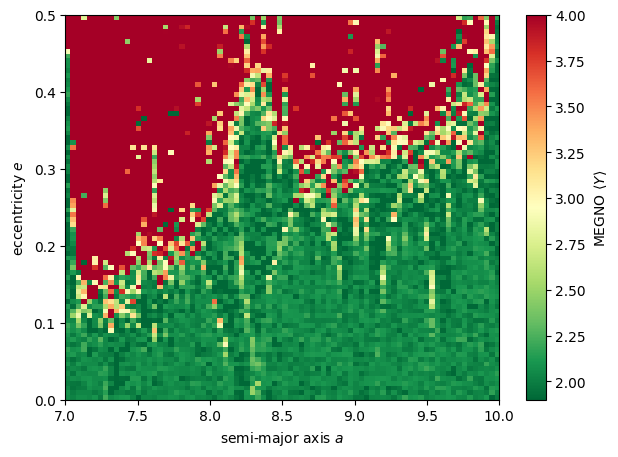

In [5]:
results2d = np.array(results).reshape(Ngrid,Ngrid)
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(par_a),max(par_a),min(par_e),max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(results2d, interpolation="none", vmin=1.9, vmax=4, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")